
### Factors contributing to the development of the complications from prediabetes in geriatric patients


The Notebook represent the workflow I used during the pts assessment

Used Tables: 

1. Conditions
2. Observations
3. Patients
4. Medications

**Geriatric pts are pts above the 65 years old**

I looked into three main conditions related to the DM in geriatric population: 

**The main complications from the DM:**

1. Retinopathy
2. Kidney issues 
3. Anemia 
4. Diabetes

Some patients do developed DM from the prediabetic stage, some olready come with diabetic diagnosis 

In [1]:
# import the libraries
import pandas as pd
import numpy as np

### Logic.

I used to work with EHR audit log, where all points presented in one table and ordered by the timestamp 
First lets create the audit log of the DM pts. 

In order to do assemble the audit log, we need to find the relation between the following tables and merge them: condition, medication, demographic, observation tables.  

In [3]:
path = '/Users/zulfiiaditto/Desktop/bigData/final_project/patient_data/'

In [4]:
############### working with the condition db ############

In [5]:
df = pd.read_csv(path + 'conditions.csv')

In [6]:
# creating the list of the diabetic patients ID which we going 
#to use over the multiple tables and then clean those again by age 

ptsD =  df.loc[(df.DESCRIPTION.str.contains('Prediabetes')) | 
               (df.DESCRIPTION.str.contains('Diabete'))].PATIENT.unique()

In [7]:
dfD = df.loc[df.PATIENT.isin(ptsD)].copy()
dfD.shape

(489193, 6)

In [8]:
dfD.head(3)

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
0,1973-12-22,NaN,f1639046-ecb1-b409-21d3-85a7e8e23c81,47a338d3-4e76-fdfd-564c-7c68e1d815f7,19169002,Miscarriage in first trimester
1,1992-12-02,NaN,f851859f-b0fe-8b36-9939-4276b96d302d,ed3e50dd-ebdf-eaee-a261-f6603ac25e05,162864005,Body mass index 30+ - obesity (finding)
2,1996-12-11,NaN,f851859f-b0fe-8b36-9939-4276b96d302d,e56964f0-e8a2-816e-e974-a05722171550,44054006,Diabetes


In [9]:
dfD.dtypes

START          object
STOP           object
PATIENT        object
ENCOUNTER      object
CODE            int64
DESCRIPTION    object
dtype: object

In [10]:
#Description column will have the "History of anemia" -> 
#remoring all the rows with history 

dfD = dfD.loc[~dfD.DESCRIPTION.str.startswith('History')]


In [11]:
dfD = dfD.sort_values(by = 'START') # ordering by the start timestamp
dfD.head()

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
613498,1921-06-16,NaN,f9eb7600-f72a-7226-6019-d854a98747af,20305127-7b64-3863-8b1e-e5c5ebf466c2,128613002,Seizure disorder
613500,1921-06-16,NaN,f9eb7600-f72a-7226-6019-d854a98747af,20305127-7b64-3863-8b1e-e5c5ebf466c2,84757009,Epilepsy
307744,1921-08-10,NaN,ef88888f-9234-5694-86b9-2a5e3c9b42f2,f8b96817-30e2-51c4-4875-317244c26537,128613002,Seizure disorder
315964,1921-09-13,NaN,bbd8b747-06a7-6f55-07d8-a4ae240e255c,1df5f15c-26e4-d240-c028-3891e041c7ba,128613002,Seizure disorder
88464,1921-09-30,NaN,13351eed-1809-efd4-4a36-a1e11ac8bcc4,82c76a1a-9328-e418-fda7-39a9122f07cc,128613002,Seizure disorder


In [12]:
################### working with observation table ############

observation = pd.read_csv(path + 'observations.csv')

# pulling out onle the pts with has DM or prediabetes 
obs = observation.loc[observation.PATIENT.isin(ptsD)].copy()
obs = obs.rename(columns = {"DATE" : "START"})

In [13]:
obs.shape

(23867815, 8)

In [14]:
# append observation table to the condition table 
dfD = dfD.append(obs)

In [15]:
################ working with the medication table #################

# use the same logic 
medications = pd.read_csv(path + 'medications.csv')
meds = medications.loc[medications.PATIENT.isin(ptsD)] 

dfD = dfD.append(meds.drop(['CODE', 'REASONCODE'], axis = 1))

In [16]:
################ working with the devices table ####################
# I am hoping that hospital will provide for geriatric patients some glucose measurement instruments 
# or diabetic pumps or something to improve they quality of live 

devices = pd.read_csv(path +'devices.csv')
dev = devices.loc[devices.PATIENT.isin(ptsD), ['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'DESCRIPTION',]]

In [17]:
dfD = dfD.append(dev)

In [18]:
################### working with the demographic table ###################

dem = pd.read_csv(path +'patients.csv')

In [19]:
# the birthday column to datetime type 
dem['BIRTHDATE'] = dem['BIRTHDATE'].astype('datetime64[ns]')

In [20]:
# selecting pts of interest 
demP = dem.loc[dem.Id.isin(ptsD)].copy()


In [21]:
# renaming column for merging 
demP.rename({"Id": "PATIENT"},axis =1, inplace = True)

Lets put aside the demographic table and do little bit more owrk with the 
 dfD table:
1. Start and Stop columns need to be transfer to the datatime dtype
2. Lets find the time difference betweeb the prediabetis and other complication to occuare (logic explain bellow)


In [22]:

# dtype casting 
columns =['START', 'STOP']
for i in columns:
    dfD[i] = pd.to_datetime(dfD[i], utc=True)

In [23]:
# in order to understand the time of developing the complication -> 
# lets find the the following: 1.create the new column (dtype - datetime), and assign the value as a time when the 
#DM start 

dfD['timeofDiabetesDiag'] =pd.NaT
dfD.loc[dfD.DESCRIPTION.str.contains('Prediabete'), 'timeofDiabetesDiag']= dfD.loc[dfD.DESCRIPTION.str.contains('Prediabete'), 'START']

# lets groupby by the pts and fill the values 

dfD['timeofDiabetesDiag'] = dfD.groupby(['PATIENT'])['timeofDiabetesDiag'].ffill()
dfD['timeofDiabetesDiag'] = dfD.groupby(['PATIENT'])['timeofDiabetesDiag'].bfill()

# by substarcting the time when the DM started from the start column -> 
#find related to the DM complication time

dfD['difference'] = dfD['START'] - dfD['timeofDiabetesDiag'] 
                                                                                

Complication we are going look for (the assigned notations)
#### prediabetes -> 0
#### diabetes ->1 
#### anemia -> due to treatment/olderly  -> 2
#### kidney desiase -> 3
#### retinopathy -> 4

In [24]:
dfD['Complications'] = np.nan
dfD.loc[dfD.DESCRIPTION.str.contains('Prediabet'), 'Complications'] = 0
dfD.loc[dfD.DESCRIPTION.str.contains('Diabete'), 'Complications'] = 1
dfD.loc[dfD.DESCRIPTION.str.contains('Anemia'), 'Complications'] = 2
dfD.loc[dfD.DESCRIPTION.str.contains('Diabetic renal'), 'Complications'] = 3
dfD.loc[dfD.DESCRIPTION.str.contains('Diabetic retinopathy'), 'Complications'] = 4

In [25]:
### merging table with the demographic and total one table dfD 

DP = dfD.merge(demP, on = 'PATIENT', how = 'left')

In [26]:
# pulling out only the healthcare path for when the DM diagnosed and after -> since the difference column with 
#the DM diagnose will have 0 as a time -> pulling out everything above 0  

DPC = DP.loc[(DP.difference >= pd.Timedelta(0, unit ='D'))].copy()


In [27]:
# we need to pull out only the geriatric pts -> age above 65 
#columns = columns + ["BIRTHDATE"]

for i in ['BIRTHDATE', 'START', 'STOP']:
    DPC[i] =pd.to_datetime(DPC[i], utc=True)

DPC['year'] = DPC["START"].dt.year 
DPC['age'] = DPC['BIRTHDATE'].dt.year-DPC['year']
DPC = DPC.loc[DPC.age > 65].copy()

In [28]:
DPC.shape

(144591, 34)

In [29]:
# total geriatric pts 
len(DPC.PATIENT.unique())


11390

In [30]:
print(DPC.START.max() , DPC.START.min()) 
# timespan in dataset 

2000-08-30 02:06:29+00:00 1940-02-29 00:00:00+00:00


In [31]:
# the average time of complication developing from the prediabetis 
toCalc = DPC.groupby(['PATIENT', 'Complications'])['difference'].mean().reset_index(name = 'average')


In [32]:
toCalc.groupby('Complications')['average'].mean()

Complications
0.0                0 days 00:00:00
1.0   1413 days 03:16:26.036519872
2.0    453 days 21:07:14.856535600
3.0   2116 days 17:10:02.135231328
4.0   2364 days 19:13:58.356164384
Name: average, dtype: timedelta64[ns]

In [33]:
DPC = DPC.sort_values(by = 'START')

### lets see the pts aggregations within the different groups and complications

In [34]:
###### creating the function for easy to pivot table for further visualization 

def pivotingForViz(df, colName):
    new = df.groupby(['Complications', colName]).size().reset_index(name = 'Ptcount')
    newP = pd.pivot(new, values = 'Ptcount', columns = ['Complications'], index = colName)
    return newP

In [35]:
# little bit of statistics to see what the distribution within the different races 
raceP = pivotingForViz(DPC, 'RACE')
raceP

Complications,0.0,1.0,2.0,3.0,4.0
RACE,,,,,
asian,884.0,94.0,668.0,21.0,18.0
black,4141.0,417.0,2943.0,107.0,68.0
native,76.0,9.0,55.0,2.0,2.0
other,19.0,NaN,15.0,NaN,NaN
white,6270.0,411.0,4788.0,151.0,58.0


In [36]:
# within the gender
genderP = pivotingForViz(DPC, 'GENDER')
genderP

Complications,0.0,1.0,2.0,3.0,4.0
GENDER,,,,,
F,4914,354,3086,56,64
M,6476,577,5383,225,82


In [37]:
# see by the age group: first grouping by the age (10 years)
DPC['ageGroup'] = np.nan
DPC.loc[DPC.age <= 74 , 'ageGroup'] = "65-74"
DPC.loc[((DPC.age >=75) & (DPC.age <84)), 'ageGroup'] = '75-84'
DPC.loc[((DPC.age >=85) & (DPC.age <94)), 'ageGroup'] = '85-94'
DPC.loc[(DPC.age >=95), 'ageGroup' ] = 'above 95'

In [38]:
ageP= pivotingForViz(DPC, 'ageGroup')
ageP

Complications,0.0,1.0,2.0,3.0,4.0
ageGroup,,,,,
65-74,6617,674,5152,257,136
75-84,4773,257,3317,24,10


In [39]:
################### CREATING THE MAIN LIST OF THE PTS OF INTEREST IN GERIATRICS POPULATION ##############
ptsList = DPC.PATIENT.unique().tolist()


In [40]:
len(ptsList)
# just a spot check 

11390

#### The following lab value and vitals do contribute to development of complication snad needed appropriate managment to reach the goal value for the pts with DM or prediabetis 

#### Laboratory values -> TR, Cholesterol, High Density Lipoprotein Cholesterol and Low Density Lipoprotein Cholesterol
#### Vitals -> BP  

So we going to check the values of those parameters and we will aggregate it within a different groups


In [41]:
# lets see the TR measurments -> high level contibutes to the DM complications
# 'Triglycerides'
# 'Hypertriglyceridemia (disorder)

In [42]:
# amount of the pts with HTR 
len(DPC.loc[DPC.DESCRIPTION.str.startswith('Hypertriglyceridemia (disorder)')].PATIENT.unique())



973

In [43]:
# lets see was the TR measured in pts with the HTR 
TR = DPC.loc[DPC.DESCRIPTION.str.startswith('Hypertriglyceridemia (disorder)')]

trV = TR.loc[TR.DESCRIPTION.str.startswith('Triglycerides')]
trV

# there are 973 pts with Hypertriglyceridemia  and none of them had been measured the TR 

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION,VALUE,UNITS,TYPE,PAYER,...,GENDER,BIRTHPLACE,CITY,STATE,COUNTY,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,year,age,ageGroup


In [44]:
#### lets see the measurments of the pts in DM table 

trM = DPC.loc[DPC.DESCRIPTION.str.startswith('Triglycerides')].copy()
trM.VALUE = trM.VALUE.astype('float')
len(trM.PATIENT.unique())

243

In [45]:
len(trM.loc[trM.VALUE > 150].PATIENT.unique())
# only 32 pts is above the prefered line (with abnormal results)  


32

In [46]:
### lets see what is average of TR measure is geriatric table 
trage= trM.groupby(['PATIENT', 'ageGroup']).VALUE.mean()
trageV = trage.groupby(['ageGroup']).mean()
trageV

# older pts in our cohort has higher values compare with younger pts 

ageGroup
65-74    134.359965
75-84    208.460000
Name: VALUE, dtype: float64

In [47]:
### average TR value based on gender 
trgen = trM.groupby(['PATIENT', 'GENDER']).VALUE.mean()
trgen.groupby(['GENDER']).mean()

GENDER
F    132.694500
M    135.762583
Name: VALUE, dtype: float64

In [48]:
# average based on the Race group 
trR = trM.groupby(['PATIENT', 'RACE']).VALUE.mean()
trR.groupby(['RACE']).mean()

RACE
asian     140.556111
black     138.210676
native    146.550000
white     131.870545
Name: VALUE, dtype: float64

In [49]:
## just out of curriosity average in table 
trvalue = trM.groupby(['PATIENT']).VALUE.mean()
trvalue.mean()

134.73988892451854

In [50]:
vitals = ['Systolic Blood Pressure','Diastolic Blood Pressure',
         'Hemoglobin A1c/Hemoglobin.total in Blood','Tobacco smoking status NHIS',
         'Hemoglobin [Mass/volume] in Blood','Glucose [Mass/volume] in Serum or Plasma',]

In [51]:
########### HA1C ##########

# to manage the DM and Prediabetes -> recommendation is to obtain HA1c atleast 2ce per year 

In [52]:
DPC.loc[DPC.DESCRIPTION==vitals[2]].groupby("PATIENT").DESCRIPTION.count()
## good! we have some pts -> we can check them 

PATIENT
00debc26-922c-387b-d8b5-31fbe64c55d5    10
026707cb-0f1e-ea3f-159d-14c59691bb27     8
02c9bbdb-0d78-8105-b485-018cefd46f69     3
0369f9ee-335c-60cb-9a65-c3276651ebe5     2
05513651-c7b2-d58c-04f4-18ad373d9d70     2
                                        ..
fce7196d-c920-0cbd-2385-a0ef04e1a8c3     2
fd2c9214-6d8c-80a4-05cf-dd93fff3b1d6     1
fe283f2a-1a17-e006-87f6-66e26b2de4ff     8
ff77db2d-1559-a963-0f61-a87a3e70d568     9
ffc0740f-5673-cde3-9e3c-0be06a21b533    13
Name: DESCRIPTION, Length: 312, dtype: int64

In [53]:
ha1c = DPC.loc[DPC.DESCRIPTION==vitals[2]].copy()

In [54]:
ha1c.VALUE = ha1c.VALUE.astype(float)

In [55]:
ha1cValue = ha1c.groupby('PATIENT').VALUE.mean()
ha1cValue.mean() # for all patients 

6.068123992282645

In [56]:
ageVH = ha1c.groupby(['ageGroup']).VALUE.mean()
ageVH

ageGroup
65-74    5.967532
75-84    6.142857
Name: VALUE, dtype: float64

In [57]:
ha1c.groupby(['RACE']).VALUE.mean()

RACE
asian     6.074648
black     6.050351
native    6.100000
white     5.945144
Name: VALUE, dtype: float64

In [58]:
ha1c.groupby(['GENDER']).VALUE.mean()

GENDER
F    6.090080
M    5.945751
Name: VALUE, dtype: float64

In [59]:
# lets see how many pts had been checked 
len(ha1c.PATIENT.unique()) 
# not much the total is 11390

312

In [60]:
### let see how ofthen they perfom the H1Ac measurements
ha1c['diffHA1c'] = ha1c.groupby('PATIENT').START.diff()

In [61]:
ha1c['diffHA1c'] =ha1c['diffHA1c'] /pd.Timedelta(1, unit= 'D')

In [62]:
ha1c.tail(2)

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION,VALUE,UNITS,TYPE,PAYER,...,BIRTHPLACE,CITY,STATE,COUNTY,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,year,age,ageGroup,diffHA1c
19159941,1999-07-20 14:39:23+00:00,NaT,2169cb94-23a9-7bcc-6139-e1b309a8a955,a494d8fc-7b8d-2ca2-01ab-f04e38ebaa33,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.1,%,numeric,NaN,...,Bladensburg Maryland US,Jessup,Maryland,Anne Arundel County,838000.90,3796.90,1999,66,65-74,190.478079
16649802,2000-08-20 00:31:20+00:00,NaT,52884dff-bbd4-d9e8-3d40-bdf0efa27bfb,d3032208-8b06-121a-de25-4548f5f4f89d,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.3,%,numeric,NaN,...,Severn Maryland US,Calverton,Maryland,Montgomery County,980194.92,5398.28,2000,66,65-74,NaN


In [63]:
agHA1c = ha1c.groupby('PATIENT').diffHA1c.mean().reset_index()
agHA1c.diffHA1c.mean()
# per patient the measurements happend every year and 4 month -> too long 

487.8587173726913

In [64]:
ageHa1c = ha1c.groupby('ageGroup').diffHA1c.mean()
ageHa1c
# so twice per year it is two counts with the 182.5 (365 days/2) days time frame. 
# aggregation per age group gave as everyyear or year and 3 month duration. 
# In both cases this average is too long. 

ageGroup
65-74    368.314747
75-84    471.560976
Name: diffHA1c, dtype: float64

In [65]:
# similar logic observed with the gender aggregation 
ha1c.groupby('GENDER').diffHA1c.mean()

GENDER
F    422.948368
M    358.941108
Name: diffHA1c, dtype: float64

In [66]:
ha1c.groupby('RACE').diffHA1c.mean()
# the race point that native americans has max days 

RACE
asian      348.395833
black      360.253713
native    1099.000000
white      388.616121
Name: diffHA1c, dtype: float64

In [67]:
############ Cholesterol & H1C & BP 
Bp = DPC.loc[DPC.DESCRIPTION.isin(vitals[:2])].copy()
Bp.VALUE = Bp.VALUE.astype(float)

In [68]:
### systolic BP 
sys = Bp.loc[Bp.DESCRIPTION.isin([vitals[0]])].groupby(['PATIENT']).VALUE.mean()
sys.mean()
#### normal systolic BP per pt 

123.4937159484035

In [69]:
Bp.loc[Bp.DESCRIPTION.isin([vitals[0]])].VALUE.mean()
# just a mean in a table without the aggregation per pt -> not a big difference

123.73995077932732

In [70]:
Bp.loc[Bp.DESCRIPTION.isin([vitals[0]])].groupby(['RACE']).VALUE.mean()
# normal BP per race groups

RACE
asian     121.319444
black     125.286747
native    134.333333
white     123.054870
Name: VALUE, dtype: float64

In [71]:
Bp.loc[Bp.DESCRIPTION.isin([vitals[0]])].groupby(['GENDER']).VALUE.mean()

GENDER
F    124.671159
M    123.332547
Name: VALUE, dtype: float64

In [72]:
Bp.loc[Bp.DESCRIPTION.isin([vitals[0]])].groupby(['ageGroup']).VALUE.mean()

ageGroup
65-74    123.470311
75-84    125.550633
Name: VALUE, dtype: float64

In [73]:
dis = Bp.loc[Bp.DESCRIPTION.isin([vitals[1]])].groupby(['PATIENT']).VALUE.mean()
dis.mean()
### normal Diastolic bp per pts -> assuming that if Systolic BP is ok within the 
# groups the Diastolic would be normal too


82.1994444657906

In [74]:
##### cholesterol 
cholPT = DPC.loc[DPC.DESCRIPTION.str.contains('Total Cholesterol')].copy()
cholPT.VALUE = cholPT.VALUE.astype(float)
chol= cholPT.groupby(['PATIENT']).VALUE.mean()
chol.mean()
##### pretty high average of CH measure per pts, consider the it should be less 170 
# lets see the parameter within the different groups

184.78482836893335

In [75]:
cholA = cholPT.groupby(['PATIENT', 'ageGroup']).VALUE.mean()
cholsForViz = cholA.groupby(['ageGroup']).mean()
cholsForViz

# both age groups values are high, especially older ones 

ageGroup
65-74    184.577654
75-84    211.670000
Name: VALUE, dtype: float64

In [76]:
chR = cholPT.groupby(['PATIENT', 'RACE']).VALUE.mean()
chR.groupby(['RACE']).mean()
# race gorups are high too 

RACE
asian     186.601111
black     186.161092
native    186.800000
white     183.728529
Name: VALUE, dtype: float64

In [77]:
chG = cholPT.groupby(['PATIENT', 'GENDER']).VALUE.mean()
chG.groupby(['GENDER']).mean()
# gender is above average too 

GENDER
F    183.281155
M    185.536665
Name: VALUE, dtype: float64

In [78]:
##### HDL 
#'High Density Lipoprotein Cholesterol'

In [79]:
hdl = DPC.loc[DPC.DESCRIPTION.str.contains('High Density Lipoprotein Cholesterol')].copy()
hdl.VALUE= hdl.VALUE.astype('float')

In [80]:
len(hdl.PATIENT.unique())

# HDL lab result had been measured only in 243 pts 

243

In [81]:
hdlA = hdl.groupby(['PATIENT']).VALUE.mean()
hdlA.mean()

66.62056079608548

In [82]:
hdlA = hdl.groupby(['PATIENT', 'ageGroup']).VALUE.mean()
hdlA.groupby(['ageGroup']).mean()
# Recommendiation for the HDL -> above 60 (the less parameter the worse)
# A reading from 41 mg/dL to 59 mg/dL is borderline low.
# => the older group had worse parameter 

ageGroup
65-74    66.755662
75-84    51.060000
Name: VALUE, dtype: float64

In [83]:
hdlG = hdl.groupby(['PATIENT', 'GENDER']).VALUE.mean()
hdlG.groupby(['GENDER']).mean()

GENDER
F    67.294965
M    66.283359
Name: VALUE, dtype: float64

In [84]:
hdlR = hdl.groupby(['PATIENT', 'RACE']).VALUE.mean()
hdlR.groupby(['RACE']).mean()

RACE
asian     65.440000
black     66.345288
native    74.800000
white     66.875300
Name: VALUE, dtype: float64

In [85]:
#Low Density Lipoprotein Cholesterol


ldl = DPC.loc[DPC.DESCRIPTION.str.contains('Low')].copy()
ldl.VALUE= ldl.VALUE.astype('float')

ldlR = ldl.groupby(['PATIENT', 'RACE']).VALUE.mean()
ldlR.groupby(['RACE']).mean()

## ldld should be less than 100 mg/dL

RACE
asian     93.051667
black     92.180972
native    82.700000
white     89.647094
Name: VALUE, dtype: float64

In [86]:
ldlg = ldl.groupby(['PATIENT', 'GENDER']).VALUE.mean()
ldlg.groupby(['GENDER']).mean()

GENDER
F    88.012169
M    92.108273
Name: VALUE, dtype: float64

In [87]:
ldlA = ldl.groupby(['PATIENT', 'ageGroup']).VALUE.mean()
ldlA.groupby(['ageGroup']).mean()

# only for older pts the value is raising 

ageGroup
65-74     90.800703
75-84    100.600000
Name: VALUE, dtype: float64

### We identify geriatrics DM pts with the high Ch measurments and small number of the HDL and borderline LDL values . 
" The 2018 American Heart Association (AHA)/American College of Cardiology (ACC)/ Multisociety guidelines for lipid management provide revised recommendations for the prevention of atherosclerotic cardiovascular disease (ASCVD). In primary prevention, statins are recommended for patients with LDL-C levels ≥190 mg/dL, patients with diabetes mellitus aged 40-75 years, and for those with no diabetes with LDL-C levels ≥70 mg/dL - <190mg/dL and 10-year ASCVD risk ≥7.5%." (https://www.acc.org/latest-in-cardiology/articles/2020/10/27/12/38/poll-results-when-do-you-start-statin-therapy-in-a-person-with-diabetes#:~:text=In%20primary%20prevention%2C%20statins%20are,year%20ASCVD%20risk%20%E2%89%A57.5%25.)


In [88]:
# so lets see how many had been prescribed with statins 

len(DPC.loc[DPC.DESCRIPTION.str.contains('statin')].PATIENT.unique())

# amount of people with statin medication -> lowering the LDL -> to prevent the cardio complications
# total number of diabetic/prediabetic pts 11390 

18

In [89]:
##### Smoking status 


In [90]:
smoke = DPC.loc[(DPC.DESCRIPTION.str.contains('Smokes tobacco daily')) 
        | DPC.DESCRIPTION.str.contains('Tobacco smoking status NHIS')]

In [91]:
smokeList = smoke.PATIENT.unique()

In [92]:
smoke.head(3)

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION,VALUE,UNITS,TYPE,PAYER,...,GENDER,BIRTHPLACE,CITY,STATE,COUNTY,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,year,age,ageGroup
6203,1942-12-27 00:00:00+00:00,NaT,5ca55499-b6c1-9ad8-c62b-b26b446582bf,ecb40657-9aac-3e8f-c3c3-95b259c8390d,449868002,Smokes tobacco daily,NaN,NaN,NaN,NaN,...,M,Waldorf Maryland US,West Laurel,Maryland,Prince George's County,1736743.26,4594.41,1942,79,75-84
22296194,1945-05-01 04:12:02+00:00,NaT,255d37c6-5a88-2616-2673-ac05c2f4c71c,f47d91df-878d-e987-ae7d-72c4bba999bf,72166-2,Tobacco smoking status NHIS,Former smoker,NaN,text,NaN,...,F,Crofton Maryland US,Cockeysville,Maryland,Baltimore County,74397.53,2407.55,1945,81,75-84
10943183,1945-06-02 20:09:39+00:00,NaT,955dc166-4dad-6748-8b2c-c1955e97f9ee,ab61172b-a18a-6570-0a56-d60a63be64fb,72166-2,Tobacco smoking status NHIS,Former smoker,NaN,text,NaN,...,M,Robinwood Maryland US,Baltimore,Maryland,Baltimore city,4940.31,0.00,1945,78,75-84


In [93]:
# issue in table  -> see the solution bellow 
smoke.groupby(['PATIENT', 'DESCRIPTION', 'VALUE'],dropna=False).size().reset_index()

,PATIENT,DESCRIPTION,VALUE,0
0,001e67cc-69c5-c59d-a829-841d93c486a8,Smokes tobacco daily,NaN,1
1,00debc26-922c-387b-d8b5-31fbe64c55d5,Tobacco smoking status NHIS,Former smoker,10
2,026707cb-0f1e-ea3f-159d-14c59691bb27,Tobacco smoking status NHIS,Never smoker,8
3,02c9bbdb-0d78-8105-b485-018cefd46f69,Tobacco smoking status NHIS,Never smoker,3
4,03262e45-f437-7441-7a43-476a0419d97f,Smokes tobacco daily,NaN,1
...,...,...,...,...
438,fce7196d-c920-0cbd-2385-a0ef04e1a8c3,Tobacco smoking status NHIS,Former smoker,2
439,fd2c9214-6d8c-80a4-05cf-dd93fff3b1d6,Tobacco smoking status NHIS,Never smoker,1
440,fe283f2a-1a17-e006-87f6-66e26b2de4ff,Tobacco smoking status NHIS,Former smoker,8
441,ff77db2d-1559-a963-0f61-a87a3e70d568,Tobacco smoking status NHIS,Former smoker,9


In [94]:
smokedf = smoke.groupby(['PATIENT', 'DESCRIPTION', 'VALUE'],dropna=False).size().reset_index()
smokedf.loc[smokedf.VALUE.isna(), 'VALUE'] = smokedf.loc[smokedf.VALUE.isna(), 'DESCRIPTION']
smokedf.VALUE.value_counts()

Former smoker               157
Never smoker                153
Smokes tobacco daily        131
Current every day smoker      2
Name: VALUE, dtype: int64

In [95]:
# let see the pts with in each complication group 
# the diabetis group 
len(DPC.loc[(DPC.PATIENT.isin(smokeList)) & (DPC.Complications==1)].PATIENT.unique())

40

### NOTE: run first cell after the anemia sign cell -> cell 106

In [98]:
# run first cell in anemia group before running this cell 

# in anemia group 
len(DPC.loc[(DPC.PATIENT.isin(smokeList)) & (DPC.PATIENT.isin(anemiaPt))].PATIENT.unique())

349

In [99]:
smokeAnemia = DPC.loc[(DPC.PATIENT.isin(anemiaPt) & (DPC.PATIENT.isin(smokeList)))].copy()

smokeAnemia.loc[smokeAnemia.VALUE.isna(), 'VALUE'] = smokeAnemia.loc[smokeAnemia.VALUE.isna(), 'DESCRIPTION']

In [100]:
smokeCount = smokeAnemia.loc[(smokeAnemia.DESCRIPTION.str.contains('Smokes tobacco daily')) 
        | smokeAnemia.DESCRIPTION.str.contains('Tobacco smoking status NHIS')].groupby(['PATIENT', 'VALUE']).size().reset_index()

smokeCount.VALUE.value_counts()

# distributionin anemia group -> 120 smokes daily 


Smokes tobacco daily        120
Never smoker                116
Former smoker               114
Current every day smoker      1
Name: VALUE, dtype: int64

In [101]:
# group with the retinopathy 
len(DPC.loc[(DPC.PATIENT.isin(smokeList)) & (DPC.Complications==3)].PATIENT.unique())

25

In [102]:
# kidney complication 
len(DPC.loc[(DPC.PATIENT.isin(smokeList)) & (DPC.Complications==4)].PATIENT.unique())

1

In [103]:
# Smoking status is not helpful -> since too many NaN values and issue with the values 

In [104]:
vitals = ['Systolic Blood Pressure','Diastolic Blood Pressure',
         'Hemoglobin A1c/Hemoglobin.total in Blood','Tobacco smoking status NHIS',
         'Hemoglobin [Mass/volume] in Blood','Glucose [Mass/volume] in Serum or Plasma',]

### DESCRIPTIVE ANALYSIS AND VISUALIZATION 

### ANEMIA 

In [105]:
# development of the anemia 
anemiaPt = DPC.loc[DPC.Complications == 2].PATIENT.unique().tolist() # pts with anemia 

anemia = DPC.loc[DPC.PATIENT.isin(anemiaPt),['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'DESCRIPTION',
       'VALUE', 'difference','RACE', 'ETHNICITY', 'GENDER','age', 'ageGroup', 'year']].sort_values(by = "START")
anemia['differrenceYear'] = anemia['difference']/pd.Timedelta(365)
anemia['differrenceYear'] = anemia['differrenceYear'].round(2)

In [106]:
# number of pts with anemia from all table 
len(anemia.PATIENT.unique())

8469

#### For pts with Prediabetes or DM metformin one of the common drug to lower glucose, however, it is may cause anemia 


In [107]:
len(anemia.loc[anemia.DESCRIPTION.str.contains('Metformin')].PATIENT.unique())
# number of pts with metformin prescription -> not much -> can assume it is olderly anemia 
# due to lifestayle and nutrision problems 

279

In [108]:
# those two medication had been found in db 
anemiaTreatment = ['Vitamin B 12 5 MG/ML Injectable Solution','ferrous sulfate 325 MG Oral Tablet',]


In [109]:
# the anemia treatment includes only the VIt B 12 injection and only for the 22 anemic pts 
len(anemia.loc[anemia.DESCRIPTION.isin(anemiaTreatment)].PATIENT.unique())

1677

In [110]:
### pts with no treatment and with metformin treatment 

notreatment = anemia.loc[~anemia.DESCRIPTION.isin(anemiaTreatment)]
len(notreatment.loc[notreatment.DESCRIPTION.str.contains('Metformin')].PATIENT.unique())

279

In [111]:
### hg measurment 
hg = anemia.loc[anemia.DESCRIPTION==vitals[4]].copy()
hg.VALUE =hg.VALUE.astype(float)

In [112]:
len(hg.PATIENT.unique())
# number of pts with the Hg measurments from the 1677 anemic pts 

205

In [113]:
# within those pts who had been measurmed with the Hg let see the how many was with low values bellow normal range 

len(hg.loc[(hg.VALUE <12) &
           (hg.GENDER == 'F')].PATIENT.unique()) +len(hg.loc[(hg.VALUE <13) 
                                                             & (hg.GENDER == 'M')].PATIENT.unique())
# number of pts with low Hg measurments 

142

In [114]:
# lets see some pts with who had been recovered 
ptCompliteAN = anemia.loc[anemia.DESCRIPTION.str.contains('Anemia') & anemia.STOP.notna()].PATIENT.unique()
ptCompliteAN 
# only two pts who had been recovered from anemia -> the rest is unknown 

array(['02c9bbdb-0d78-8105-b485-018cefd46f69',
       '490680df-fdf5-f017-7dbd-663eddfbcc31'], dtype=object)

In [115]:
# total number of pts with the measured Hgb is 205 -> however only 142 of 
# them has low value of the hgb and only 2 pts had been documented with end of the anemia day 


In [116]:
counthg = hg.groupby(['PATIENT', 'year'])['VALUE'].count().reset_index()
counthg.VALUE.mean() # average of the Hg measurment per year 

1.2349397590361446

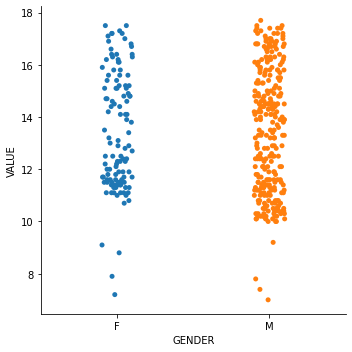

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.catplot(x = 'GENDER',y = 'VALUE' , data=hg[['GENDER', 'VALUE']])
plt.show()
# the distribution of hbd values in table  

In [118]:
# lets see how the different parameters we looked at contribute more or less to the anemia complication

In [119]:
import statsmodels.formula.api as smf

resA = smf.ols(formula='differrenceYear ~ age + C(GENDER) + C(RACE)', data=anemia[[ "GENDER", "age",
                                                                                'RACE', 'differrenceYear']]).fit()
resA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        differrenceYear   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     7093.
Date:                Sat, 23 Apr 2022   Prob (F-statistic):               0.00
Time:                        20:07:33   Log-Likelihood:            -4.2101e+06
No. Observations:              121113   AIC:                         8.420e+06
Df Residuals:                  121106   BIC:                         8.420e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           3.56e+15   1.57e+13    226.153      0.000    3.53e+15    3.59e+15
C(GENDER)[T.M]     1.145e+13   1.83e+12      6.266      0.000    7.87e+12     1.5e+13
C(RACE)[T.black]   -1.11e+12   3.43e+12     -0.324      0.746   -7.82e+12     5.6e+12
C(RACE)[T.native]  -9.94e+13   1.28e+13     -7.772      0.000   -1.24e+14   -7.43e+13
C(RACE)[T.other]   3.264e+11   2.42e+13      0.013      0.989   -4.71e+13    4.77e+13
C(RACE)[T.white]  -1.378e+13   3.31e+12     -4.159      0.000   -2.03e+13   -7.29e+12
age               -4.448e+13   2.17e+11   -205.368      0.000   -4.49e+13   -4.41e+13
==============================================================================
Omnibus:                     4928.412   Durbin-Watson:                   0.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2158.267
Skew:                           0.060   Prob(JB):                         0.00
Kurtosis:                       2.357   Cond. No.                     1.98e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [120]:
# model explains only the 26% (see the R^2) of the timedifference between the oncet  of the prediabetes and anemia occurence, 
# which is logical, we did not include the initial condition of the pts into model and other lifestyle factors


In [121]:
resA.params
#SO if you younger in age, or native or black or white -> you may get anemia as a complication later in a row 
# However, if you are male and race gorup other it may happened sooner 

Intercept            3.559643e+15
C(GENDER)[T.M]       1.145351e+13
C(RACE)[T.black]    -1.109504e+12
C(RACE)[T.native]   -9.940142e+13
C(RACE)[T.other]     3.264115e+11
C(RACE)[T.white]    -1.378325e+13
age                 -4.447979e+13
dtype: float64

### Prediabetes -> Diabetes 

In [122]:
diabetesPt = DPC.loc[DPC.Complications.isin([0,1])].PATIENT.unique().tolist() 
diabetes = DPC.loc[DPC.PATIENT.isin(diabetesPt),['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'DESCRIPTION',
       'VALUE', 'difference','RACE', 'ETHNICITY', 'GENDER','age', 'ageGroup', 'year', "Complications"]].sort_values(by = "START")

In [123]:
diabetes.shape

(144591, 14)

In [124]:
len(diabetes.PATIENT.unique())

11390

In [125]:
# filter the pats with prediabetes and diabets in ds 
# NOTE: not all pts develop diabetes from prediabetes or they may leave clinic -> selecting pts who had been stay 


onlyPDD = diabetes.loc[(diabetes.Complications==1) | 
                     (diabetes.Complications ==0)].groupby(['PATIENT']).filter(lambda x : len(x.Complications.unique())==2)


In [126]:
len(onlyPDD.PATIENT.unique())

931

In [127]:
onlyD = onlyPDD.loc[onlyPDD.Complications ==1, ['PATIENT', 'difference', 'age', 'Complications', 'ENCOUNTER','GENDER', 'RACE']]
onlyD['differrenceYear'] = onlyD['difference']/pd.Timedelta(365)
onlyD['differrenceYear'] =onlyD['differrenceYear'].round(2)

In [128]:
import statsmodels.formula.api as smf

res = smf.ols(formula='differrenceYear ~ age + C(GENDER) + C(RACE)', data=onlyD[[ "GENDER", "age",
                                                                                'RACE', 'differrenceYear']]).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        differrenceYear   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     12.39
Date:                Sat, 23 Apr 2022   Prob (F-statistic):           1.17e-11
Time:                        20:07:35   Log-Likelihood:                -31704.
No. Observations:                 931   AIC:                         6.342e+04
Df Residuals:                     925   BIC:                         6.345e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.014e+15   9.57e+13     10.593      0.000    8.26e+14     1.2e+15
C(GENDER)[T.M]     6.747e+12   1.01e+13      0.666      0.505   -1.31e+13    2.66e+13
C(RACE)[T.black]   1.614e+13   1.71e+13      0.945      0.345   -1.74e+13    4.96e+13
C(RACE)[T.native]  1.177e+14   5.22e+13      2.255      0.024    1.53e+13     2.2e+14
C(RACE)[T.white]   2.002e+13   1.71e+13      1.171      0.242   -1.35e+13    5.36e+13
age               -9.796e+12   1.32e+12     -7.417      0.000   -1.24e+13    -7.2e+12
==============================================================================
Omnibus:                       28.463   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.206
Skew:                           0.325   Prob(JB):                     5.54e-06
Kurtosis:                       2.550   Cond. No.                     1.40e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [129]:
# our model is explaining only 6% of the dependent variable behavior.
# But we used a small dataset 931 rows only :( 


In [130]:
res.params # Female gender is time difference between developing the complications is decreasing
# as age groun the time is decreasing as well 


Intercept            1.013812e+15
C(GENDER)[T.M]       6.747191e+12
C(RACE)[T.black]     1.613713e+13
C(RACE)[T.native]    1.177254e+14
C(RACE)[T.white]     2.002384e+13
age                 -9.795844e+12
dtype: float64

### Retinopathy 

In [131]:
retinoPt = DPC.loc[DPC.Complications == 4].PATIENT.unique().tolist() 
retinopath = DPC.loc[DPC.PATIENT.isin(retinoPt),['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'DESCRIPTION',
       'VALUE', 'difference','RACE', 'ETHNICITY', 'GENDER','age', 'ageGroup', 'year', "Complications"]].sort_values(by = "START")

retinopath['differrenceYear'] = retinopath['difference']/pd.Timedelta(365)
retinopath['differrenceYear'] = retinopath['differrenceYear'].round(2)


In [132]:
retinopath.shape 
# checking the BP, cholesterol, A1c , age, gender 

(4608, 15)

In [133]:
len(retinopath.PATIENT.unique())

146

In [134]:
newVitals = vitals[:3]+['Total Cholesterol']
vitalsRet = retinopath.loc[retinopath.DESCRIPTION.isin(newVitals), ["START", 
                                                                     'PATIENT','VALUE', "DESCRIPTION",]]

In [135]:
vitalsRet.PATIENT.unique()
# ha from all group only one pts who had been measured with 
#'Diastolic Blood Pressure', "Hemoglobin A1c/Hemoglobin.total in Blood", "Systolic Blood Pressure" 


array(['d771ba72-4755-9004-18bd-4799107531e8'], dtype=object)

In [136]:
import statsmodels.formula.api as smf

resR = smf.ols(formula='differrenceYear ~ age + C(GENDER) + C(RACE)', data=retinopath[[ "GENDER", "age",
                                                                                'RACE', 'differrenceYear']]).fit()
resR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        differrenceYear   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     687.3
Date:                Sat, 23 Apr 2022   Prob (F-statistic):               0.00
Time:                        20:07:35   Log-Likelihood:            -1.5972e+05
No. Observations:                4608   AIC:                         3.195e+05
Df Residuals:                    4602   BIC:                         3.195e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.881e+15   7.63e+13     63.987      0.000    4.73e+15    5.03e+15
C(GENDER)[T.M]    -7.329e+13   8.48e+12     -8.642      0.000   -8.99e+13   -5.67e+13
C(RACE)[T.black]   5.887e+13   1.42e+13      4.149      0.000    3.11e+13    8.67e+13
C(RACE)[T.native] -1.993e+14   3.57e+13     -5.576      0.000   -2.69e+14   -1.29e+14
C(RACE)[T.white]   9.829e+12   1.41e+13      0.699      0.484   -1.77e+13    3.74e+13
age               -6.135e+13   1.06e+12    -57.687      0.000   -6.34e+13   -5.93e+13
==============================================================================
Omnibus:                       89.246   Durbin-Watson:                   0.653
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.717
Skew:                          -0.304   Prob(JB):                     1.48e-19
Kurtosis:                       2.715   Cond. No.                     1.34e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [137]:
resR.params

Intercept            4.881251e+15
C(GENDER)[T.M]      -7.328619e+13
C(RACE)[T.black]     5.887155e+13
C(RACE)[T.native]   -1.992760e+14
C(RACE)[T.white]     9.829363e+12
age                 -6.134554e+13
dtype: float64

In [138]:
retinopath.head()

,START,STOP,PATIENT,ENCOUNTER,DESCRIPTION,VALUE,difference,RACE,ETHNICITY,GENDER,age,ageGroup,year,Complications,differrenceYear
4146,1940-10-18 00:00:00+00:00,NaT,42eab8d9-b68d-c6f7-0411-43a69727482e,064c30e1-7e2a-e449-3886-d519fd6cd52a,Anemia (disorder),NaN,0 days 00:00:00,asian,nonhispanic,F,81,75-84,1940,2.0,0.000000e+00
4147,1940-10-18 00:00:00+00:00,NaT,42eab8d9-b68d-c6f7-0411-43a69727482e,064c30e1-7e2a-e449-3886-d519fd6cd52a,Prediabetes,NaN,0 days 00:00:00,asian,nonhispanic,F,81,75-84,1940,0.0,0.000000e+00
27805055,1940-10-18 17:56:21+00:00,1941-10-24 17:56:21+00:00,42eab8d9-b68d-c6f7-0411-43a69727482e,e069fb6e-505b-b03c-dc11-00f26e33fd5f,Hydrochlorothiazide 25 MG Oral Tablet,NaN,0 days 17:56:21,asian,nonhispanic,F,81,75-84,1940,NaN,1.769342e+11
27805056,1940-10-18 17:56:21+00:00,1941-10-24 17:56:21+00:00,42eab8d9-b68d-c6f7-0411-43a69727482e,e069fb6e-505b-b03c-dc11-00f26e33fd5f,amLODIPine 2.5 MG Oral Tablet,NaN,0 days 17:56:21,asian,nonhispanic,F,81,75-84,1940,NaN,1.769342e+11
27805054,1940-10-18 17:56:21+00:00,1940-10-18 17:56:21+00:00,42eab8d9-b68d-c6f7-0411-43a69727482e,064c30e1-7e2a-e449-3886-d519fd6cd52a,amLODIPine 2.5 MG Oral Tablet,NaN,0 days 17:56:21,asian,nonhispanic,F,81,75-84,1940,NaN,1.769342e+11


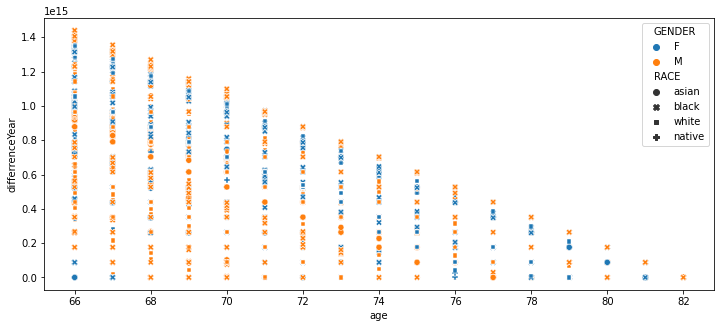

In [139]:
plt.figure(figsize = (12,5))
sns.scatterplot(data=retinopath[['differrenceYear', 'age', 'GENDER', 'RACE']], y='differrenceYear',
                x ='age', hue = 'GENDER',  style='RACE')
plt.show()

### Kidney issue 

In [140]:
kidneyPt = DPC.loc[DPC.Complications == 3].PATIENT.unique().tolist() 
kidney = DPC.loc[DPC.PATIENT.isin(kidneyPt),['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'DESCRIPTION',
       'VALUE', 'difference','RACE', 'ETHNICITY', 'GENDER','age', 'ageGroup', 'year', "Complications"]].sort_values(by = "START")


In [141]:

kidney['differrenceYear'] = kidney['difference']/pd.Timedelta(365)
kidney['differrenceYear'] = kidney['differrenceYear'].round(2)

In [142]:
kidney.shape

(15272, 15)

In [143]:
len(kidney.PATIENT.unique())

281

In [144]:
kidn = kidney.loc[((kidney.Complications == 3) & 
                (kidney.difference >'0 days'))]

In [145]:
import statsmodels.formula.api as smf

resK = smf.ols(formula='differrenceYear ~ age + C(GENDER) + C(RACE)', data=kidney[[ "GENDER", "age",
                                                                                'RACE', 'differrenceYear']]).fit()
resK.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        differrenceYear   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     1685.
Date:                Sat, 23 Apr 2022   Prob (F-statistic):               0.00
Time:                        20:07:36   Log-Likelihood:            -5.2979e+05
No. Observations:               15272   AIC:                         1.060e+06
Df Residuals:                   15266   BIC:                         1.060e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.866e+15   4.84e+13    100.616      0.000    4.77e+15    4.96e+15
C(GENDER)[T.M]     8.469e+13   6.21e+12     13.635      0.000    7.25e+13    9.69e+13
C(RACE)[T.black]  -4.914e+13   9.45e+12     -5.199      0.000   -6.77e+13   -3.06e+13
C(RACE)[T.native]  1.121e+14   3.03e+13      3.694      0.000    5.26e+13    1.72e+14
C(RACE)[T.white]  -9.257e+13   9.17e+12    -10.096      0.000   -1.11e+14   -7.46e+13
age               -6.142e+13   6.81e+11    -90.221      0.000   -6.28e+13   -6.01e+13
==============================================================================
Omnibus:                      427.719   Durbin-Watson:                   0.568
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              339.770
Skew:                          -0.285   Prob(JB):                     1.66e-74
Kurtosis:                       2.543   Cond. No.                     1.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [146]:
resK.params

Intercept            4.865523e+15
C(GENDER)[T.M]       8.468931e+13
C(RACE)[T.black]    -4.914276e+13
C(RACE)[T.native]    1.120709e+14
C(RACE)[T.white]    -9.256506e+13
age                 -6.142005e+13
dtype: float64

In [147]:
vitalsKidn = kidney.loc[kidney.DESCRIPTION.isin(newVitals), ["START", 'PATIENT','VALUE', "DESCRIPTION",]]
vitalsKidn.shape

(344, 4)

In [148]:
vitalsKidn.head(3)

,START,PATIENT,VALUE,DESCRIPTION
498886,1953-07-22 10:33:10+00:00,60fe72da-8d07-00b3-4fc4-2193ec361ef9,6.6,Hemoglobin A1c/Hemoglobin.total in Blood
498868,1953-07-22 10:33:10+00:00,60fe72da-8d07-00b3-4fc4-2193ec361ef9,132.0,Systolic Blood Pressure
498879,1953-07-22 10:33:10+00:00,60fe72da-8d07-00b3-4fc4-2193ec361ef9,203.8,Total Cholesterol


In [149]:
vitalKid = pd.pivot(vitalsKidn, values = 'VALUE', index = ['PATIENT', 'START'],  columns = ["DESCRIPTION"])
vitalKid = vitalKid.reset_index()
vitalKid.head()

DESCRIPTION,PATIENT,START,Diastolic Blood Pressure,Hemoglobin A1c/Hemoglobin.total in Blood,Systolic Blood Pressure,Total Cholesterol
0,4ef5b233-0815-d50d-8f2b-61e8d2038b9e,1968-09-25 10:46:45+00:00,115.0,7.6,146.0,202.9
1,4ef5b233-0815-d50d-8f2b-61e8d2038b9e,1969-10-01 10:46:45+00:00,98.0,6.1,161.0,245.1
2,4ef5b233-0815-d50d-8f2b-61e8d2038b9e,1970-10-07 10:46:45+00:00,117.0,6.1,144.0,170.5
3,4ef5b233-0815-d50d-8f2b-61e8d2038b9e,1971-10-13 10:46:45+00:00,97.0,6.1,171.0,181.1
4,4ef5b233-0815-d50d-8f2b-61e8d2038b9e,1972-04-05 10:46:45+00:00,101.0,6.1,142.0,181.1


In [150]:
len(vitalKid.PATIENT.unique())

10

In [151]:
#Hemodialysis machine device (physical object)
dev.loc[dev.PATIENT.isin(kidneyPt)].DESCRIPTION.unique()

array(['Implantable defibrillator  device (physical object)',
       'Implantable cardiac pacemaker (physical object)',
       'Coronary artery stent (physical object)',
       'Mechanical ventilator (physical object)',
       'Videolaryngoscope (physical object)',
       'Hemodialysis machine  device (physical object)'], dtype=object)

In [152]:
############################## VIZUALIZATION ##################
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.models import Panel, Tabs
from bokeh.models import Span
from math import pi
from bokeh.palettes import Category20c, Pastel1
from bokeh.transform import cumsum

output_file('dashDMFinalAssigment.html')


################# visualization of the time of developing complications from preDM 
listTime = [1413, 453,2116, 2116 ]
yearList= [int(x/365) for x in listTime]


factors = ['Diabetes', 'Anemia', 'Kidney Issues', "Retinopathy" ]
x =  yearList

p = figure(title="Average time of developing complication from prediabetes diagnosis", tools="", toolbar_location=None,
           y_range=factors, x_range=[0,10],  x_axis_label="years")

p.segment(0, factors, x, factors, line_width=2, line_color="purple", )
p.circle(x, factors, size=15, fill_color="pink", line_color="purple", line_width=3, )

###### visualization complication vs Race 

complications = ['Prediabetis', 'Diabetis', 'Anemia', 'Kidney issue', 'Retinopathy']
race = ["race: asian", 'race: black',  'race: white']
colors = ['#b3e2cd',
'#fdcdac',
'#cbd5e8']

data = {'complications' : complications,
        'race: asian'   : raceP.iloc[0].values.tolist(),
        'race: black'   : raceP.iloc[1].values.tolist(),
        'race: white' : raceP.iloc[4].values.tolist(),
       }

com = figure(x_range=complications, title="Count of pts with different complications per race group",
           toolbar_location=None, tools="hover", tooltips="$name @complications: @$name", 
              y_axis_label = "Patient count", )

com.vbar_stack(race, x='complications', width=0.9, color=colors, source=data,line_color = "black", line_width =0.5, 
             legend_label=race)

com.y_range.start = 0
com.x_range.range_padding = 0.1
com.xgrid.grid_line_color = None
com.axis.minor_tick_line_color = None
com.outline_line_color = None
com.legend.location = "top_right"
com.legend.orientation = "vertical"


####### gender
gender = ["female", 'male']
colors = ['#b3e2cd',
'#fdcdac',
]

data = {'complications' : complications,
        'female'   : genderP.iloc[0].values.tolist(),
        'male'   : genderP.iloc[1].values.tolist(),}

gen = figure(x_range=complications, title="Count of pts with different complications per gender",
           toolbar_location=None, tools="hover", tooltips="$name @complications: @$name",
              y_axis_label = "Patient count", )

gen.vbar_stack(gender, x='complications', width=0.9, color=colors, source=data, line_color = "black", line_width =0.5, 
             legend_label=gender)

gen.y_range.start = 0
gen.x_range.range_padding = 0.1
gen.xgrid.grid_line_color = None
gen.axis.minor_tick_line_color = None
gen.outline_line_color = None
gen.legend.location = "top_right"
gen.legend.orientation = "vertical"

############ vizualization of the agegroup vs complications

age = ["65-74", '75-84']
colors = ['#b3e2cd',
'#fdcdac',
]

data = {'complications' : complications,
        '65-74'   : ageP.iloc[0].values.tolist(),
        '75-84'   : ageP.iloc[1].values.tolist(),}

ageGr = figure(x_range=complications, title="Count of pts with different complications per ageGroup",
           toolbar_location=None, tools="hover", tooltips="$name @complications: @$name", 
              y_axis_label = "Patient count", )

ageGr.vbar_stack(age, x='complications', width=0.9, color=colors, source=data,line_color = "black", line_width =0.5, 
             legend_label=age)

ageGr.y_range.start = 0
ageGr.x_range.range_padding = 0.1
ageGr.xgrid.grid_line_color = None
ageGr.axis.minor_tick_line_color = None
ageGr.outline_line_color = None
ageGr.legend.location = "top_right"
ageGr.legend.orientation = "vertical"

################################# Interesting facts during the analysis
####### ANEMIA Vizualization 

value = [8469, 1677, 279, 202]
barName =['Anemia', 'NoTreatment', 'Metformin + NoTretament', '# pts with Hgb measures']


x = {"NoTreatment" : 8469-1677 - 279,
    'Treatment': 1677,
    'Metformin + NoTretament' : 279, 
}

data = pd.Series(x).reset_index(name='value').rename(columns={'index': 'parameter'})
data['angle'] = data['value']/data['value'].sum() * 2*pi
data['color'] = Pastel1[len(x)]

a = figure( title="Count of pts with anemia complication + with/without anemia treatment", toolbar_location=None,
           tools="hover", tooltips="@parameter: @value", x_range=(-0.5, 1.0))

a.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="black", fill_color='color', legend_field='parameter', source=data)

a.axis.axis_label = None
a.axis.visible = False
a.grid.grid_line_color = None

####### hgb measurments 
hg = {"Number of anemic pts without Hgb measurements" : 8469,
    
    'Hgb in normal range' : 205-142,
    'Hgb bellow the normal range' : 142
}

dataH = pd.Series(hg).reset_index(name='value').rename(columns={'index': 'parameter'})
dataH['angle'] = dataH['value']/dataH['value'].sum() * 2*pi
dataH['color'] = Pastel1[len(hg)]

hgb = figure( title="Count of pts with anemia + with/without Hgb measures", toolbar_location=None,
           tools="hover", tooltips="@parameter: @value", x_range=(-0.5, 1.0))

hgb.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="black", fill_color='color', legend_field='parameter', source=dataH)

hgb.axis.axis_label = None
hgb.axis.visible = False
hgb.grid.grid_line_color = None


########## HTR comorbility 

xTR = {"Diabetic pts" : 11390-973,
    'Diabetic pts with Hypertriglyceridemia': 973,
   
}

dataTR = pd.Series(xTR).reset_index(name='value').rename(columns={'index': 'parameter'})
dataTR['angle'] = dataTR['value']/dataTR['value'].sum() * 2*pi
dataTR['color'] = ['#fbb4ae', '#b3cde3']

tr = figure( title="Count of prediabetic/diabetic pts + with/without Hypertriglyceridemia", toolbar_location=None,
           tools="hover", tooltips="@parameter: @value", x_range=(-0.5, 1.0))

tr.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="black", fill_color='color', legend_field='parameter', source=dataTR)

tr.axis.axis_label = None
tr.axis.visible = False
tr.grid.grid_line_color = None

########## TR measurements

xTRM = {"Diabetic pts without TR measurements" : 11390-243,
    "Diabetic pts with TR measurements": 243
}

dataTRM = pd.Series(xTRM).reset_index(name='value').rename(columns={'index': 'parameter'})
dataTRM['angle'] = dataTRM['value']/dataTRM['value'].sum() * 2*pi
dataTRM['color'] = ['#fbb4ae', '#b3cde3']

trm = figure( title="Count of prediabetic/diabetic pts + with/without Triglycerides measurement", toolbar_location=None,
           tools="hover", tooltips="@parameter: @value", x_range=(-0.5, 1.0))

trm.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="black", fill_color='color', legend_field='parameter', source=dataTRM)

trm.axis.axis_label = None
trm.axis.visible = False
trm.grid.grid_line_color = None

########## cholesterol average value 

ages = cholsForViz.index.tolist()
counts = cholsForViz.values

agCH = figure(x_range=ages, title="Average of Total Cholesterol measurement in pts with DM per age groups",
           toolbar_location=None, tools="", y_axis_label = 'mg/dL', x_axis_label = 'age groups')

agCH.vbar(x=ages, top=counts, width=0.7, alpha = 0.5,line_color = "black", line_width =0.5, )
treshold = 170
hline = Span(location=treshold, dimension='width', line_color='red', line_width=3)

agCH.renderers.extend([hline])

agCH.xgrid.grid_line_color = None
agCH.y_range.start = 0

############ TR average value 

agesT = trageV.index.tolist()
countsT = trageV.values

agTR = figure(x_range=ages, title="Average of Triglycerides measurement in pts with DM per age groups",
           toolbar_location=None, tools="", y_axis_label = 'mg/dL', x_axis_label = 'age groups')

agTR.vbar(x=agesT, top=countsT, width=0.7, alpha = 0.5,line_color = "black", line_width =0.5, )
tresholdT = 150
hlineT = Span(location=tresholdT, dimension='width', line_color='red', line_width=3)

agTR.renderers.extend([hlineT])

agTR.xgrid.grid_line_color = None
agTR.y_range.start = 0

########### H1AC number of measurements #######################
from bokeh.models import Range1d

ageH = ageHa1c.index.tolist()
valueH1ac = ageHa1c.values.tolist()

timeH1ac = figure(x_range=ageH,  title="Average time between measurments of HA1C",
           toolbar_location=None, tools="", y_axis_label = 'days')

timeH1ac.vbar(x=ageH, top=valueH1ac, line_color='black', width=0.7, alpha = 0.5, line_width =0.5,)

timeH1ac.xgrid.grid_line_color = None
timeH1ac.y_range.start = 0


treshold1 = 182
hlines1= Span(location=treshold1, dimension='width', line_color='red', line_width=3)
timeH1ac.renderers.extend([hlines1])

treshold2 = 365
hlines2 = Span(location=treshold2, dimension='width', line_color='red', line_width=3)
timeH1ac.renderers.extend([hlines2])

timeH1ac.xgrid.grid_line_color = None
timeH1ac.y_range.start = 0

############## H1AC values ################

ageRangeHV = ageVH.index.tolist()
valueHV = ageVH.values.tolist()

valueH1ac = figure(x_range=ageRangeHV,  title="Average of HA1C measurment per age groups",
           toolbar_location=None, tools="",y_axis_label = '%', x_axis_label = 'age groups')

valueH1ac.vbar(x=ageRangeHV, top=valueHV, line_color='black', width=0.7, alpha = 0.5, line_width =0.5,  )

valueH1ac.xgrid.grid_line_color = None
valueH1ac.y_range.start = 0


treshold1V = 7
hlinesV= Span(location=treshold1V, dimension='width', line_color='red', line_width=3)
valueH1ac.renderers.extend([hlinesV])
valueH1ac.y_range = Range1d(0, 8)
valueH1ac.xgrid.grid_line_color = None
valueH1ac.y_range.start = 0




##### GRID ASSEMBLE into tabs #############

anemiaGrid = gridplot([ [a,hgb ], [tr, trm],[timeH1ac,valueH1ac], [agCH, agTR]])

grid = gridplot([[p, com], [gen, ageGr]])

tab1 = Panel(child=grid,title="Complications contributing factors")
tab2 = Panel(child=anemiaGrid,title="Care managment")
tabs = Tabs(tabs=[ tab1, tab2 ])

show(tabs)


In [153]:
 ########### viz of the hgd measurment distribution -> not usefull 

#from bokeh.io import output_file, show
#from bokeh.models import ColumnDataSource
#from bokeh.plotting import figure
#from bokeh.sampledata.commits import data
#from bokeh.transform import jitter    
#genders = ['F', 'M']

#source = ColumnDataSource(hg[['GENDER', 'VALUE']].reset_index(drop= True))

#anem = figure(height=350, y_range=genders, x_axis_type='linear',
#           toolbar_location=None, sizing_mode="stretch_width",
#           title="Distribution of the hgb for the pts who Hgb had been measured", x_axis_label ="Hgb (gm/dL)")

#anem.circle(x='VALUE', y=jitter('GENDER',width=0.6, range=anem.y_range),  source=source)


#anem.x_range.range_padding = 0
#anem.ygrid.grid_line_color = None
